In [2]:
import tempfile
from pathlib import Path

import boto3
import pandas as pd

bucket = "ml-for-bem"
bucket_prefix = "hatchet"
experiment_id = "test/progressive-training-26"
experiment_id = "test/ma-lib-02"
experiment_id = "test/new-dockerfile-3"
experiment_id = "ma-webapp/v0"
experiment_id = "ma-webapp/test/v1-20250410-113041"
experiment_id = "ma-webapp/v1-20250410-135156"

s3 = boto3.client("s3")

# list all the files in the experiment directory that have "train" and "results" and "h5" in the key
files = s3.list_objects(Bucket=bucket, Prefix=f"{bucket_prefix}/{experiment_id}")[
    "Contents"
]

# filter the files to only include the ones that have "train" and "results" and "h5" in the key
train_err_h5_files = [
    file
    for file in files
    if "train/" in file["Key"] and "results" in file["Key"] and "h5" in file["Key"]
]


train_fold_err_keys = [file["Key"] for file in train_err_h5_files]

individual_fold_err_dfs = []
global_err_dfs = []
with tempfile.TemporaryDirectory() as temp_dir:
    for i, file in enumerate(train_fold_err_keys):
        local_path = Path(temp_dir) / f"result_{i}.h5"
        s3.download_file(Bucket=bucket, Key=file, Filename=local_path.as_posix())
        err_df = pd.read_hdf(local_path.as_posix(), key="stratum_metrics")
        global_err_df = pd.read_hdf(local_path.as_posix(), key="global_metrics")
        individual_fold_err_dfs.append(err_df)
        global_err_dfs.append(global_err_df)

individual_fold_err_dfs = pd.concat(individual_fold_err_dfs)
global_err_dfs = pd.concat(global_err_dfs)

train_pq_files = [file for file in files if "fold-averaged-errors" in file["Key"]]
train_pq_keys = [file["Key"] for file in train_pq_files]

fold_averaged_errs_df = pd.concat(
    [pd.read_parquet(f"s3://{bucket}/{key}").sort_index() for key in train_pq_keys],
    axis=1,
)

combined_sim_results_files = [
    file for file in files if "full-dataset.pq" in file["Key"]
]
final_combined_sim_results_key = combined_sim_results_files[-1]["Key"]
final_combined_sim_results_uri = f"s3://{bucket}/{final_combined_sim_results_key}"
combined_sim_results_df = pd.read_parquet(final_combined_sim_results_uri)

In [2]:
combined_sim_results_df.to_parquet("E:/repos/carbon-signal-linear/data/sbem-v1.pq")

In [3]:
combined_sim_results_df.groupby("experiment_id").size()

experiment_id
ma-webapp/v1-20250410-135156/iter-000/sample    99845
ma-webapp/v1-20250410-135156/iter-001/sample    19922
ma-webapp/v1-20250410-135156/iter-002/sample    19931
ma-webapp/v1-20250410-135156/iter-003/sample    19929
ma-webapp/v1-20250410-135156/iter-004/sample    19917
ma-webapp/v1-20250410-135156/iter-005/sample    19931
dtype: int64

## Checking Learning Curves

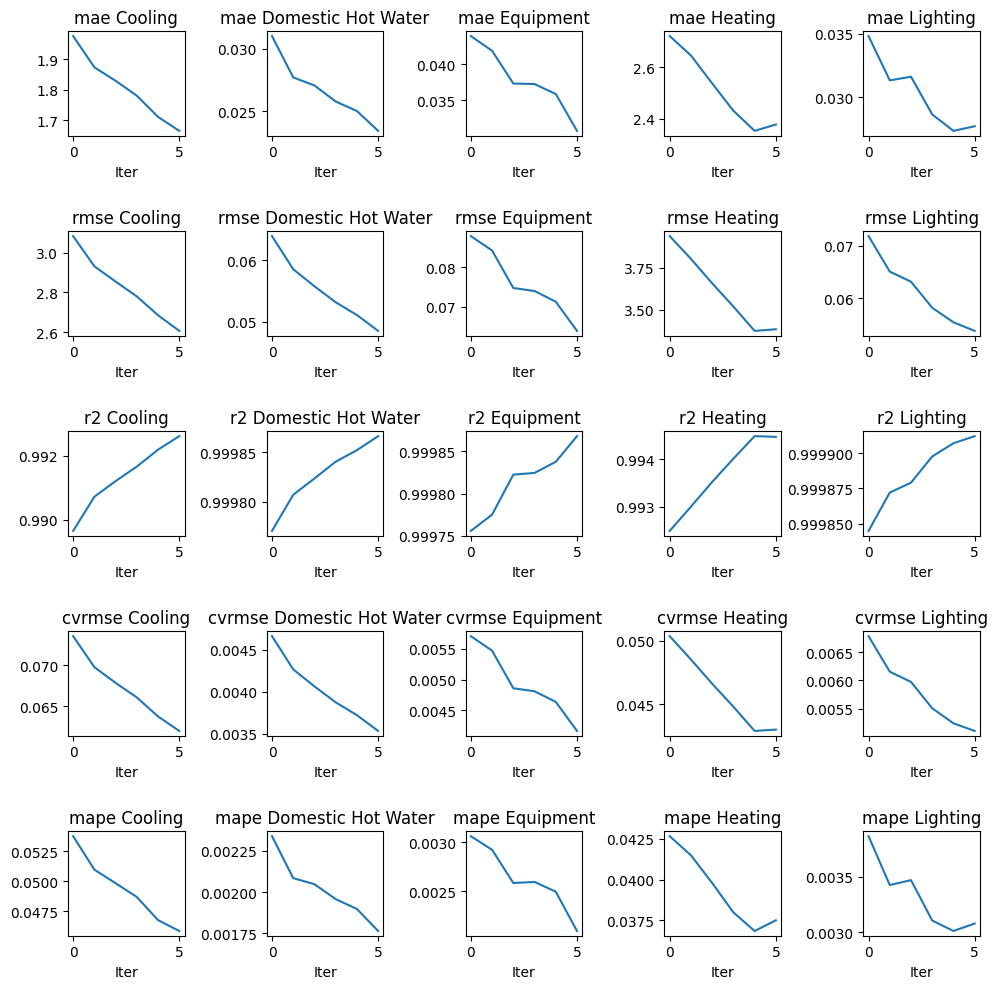

In [4]:
import matplotlib.pyplot as plt

global_errs = global_err_dfs["test"].groupby("progressive_training_iter_ix").mean()
n_err_metrics = global_errs.columns.get_level_values("metric").nunique()
n_targets = global_errs.columns.get_level_values("target").nunique()
fig, ax = plt.subplots(n_err_metrics, n_targets, figsize=(10, 10))
for i, metric in enumerate(global_errs.columns.get_level_values("metric").unique()):
    for j, target in enumerate(global_errs.columns.get_level_values("target").unique()):
        global_errs[metric, target].plot(ax=ax[i, j])
        ax[i, j].set_title(f"{metric} {target}")
        ax[i, j].set_xlabel("Iter")
fig.tight_layout()

In [5]:
(
    individual_fold_err_dfs["test"]
    .xs("mae", level="metric", axis=1)
    .xs("Heating", level="target", axis=1)
    .groupby("progressive_training_iter_ix")
    .mean()
    .T
    < 3
).mean()

progressive_training_iter_ix
0    0.847458
1    0.915254
2    0.949153
3    0.949153
4    0.983051
5    0.983051
dtype: float64

In [6]:
fold_averaged_errs_df.xs("r2", level="metric").groupby("target").min().round(3)

,0,1,2,3,4,5
target,,,,,,
Cooling,0.970,0.975,0.976,0.978,0.979,0.981
Domestic Hot Water,0.998,0.999,0.999,0.999,0.999,1.000
Equipment,0.998,0.998,0.999,0.999,0.999,1.000
Heating,0.984,0.986,0.986,0.988,0.989,0.988
Lighting,0.999,1.000,1.000,1.000,1.000,1.000


In [7]:
fold_averaged_errs_df.xs("mae", level="metric").groupby("target").max().round(2)


,0,1,2,3,4,5
target,,,,,,
Cooling,2.83,2.59,2.48,2.52,2.29,2.32
Domestic Hot Water,0.05,0.04,0.04,0.04,0.04,0.03
Equipment,0.07,0.07,0.06,0.06,0.05,0.04
Heating,4.75,4.63,4.44,4.06,3.96,4.05
Lighting,0.06,0.05,0.04,0.04,0.04,0.04


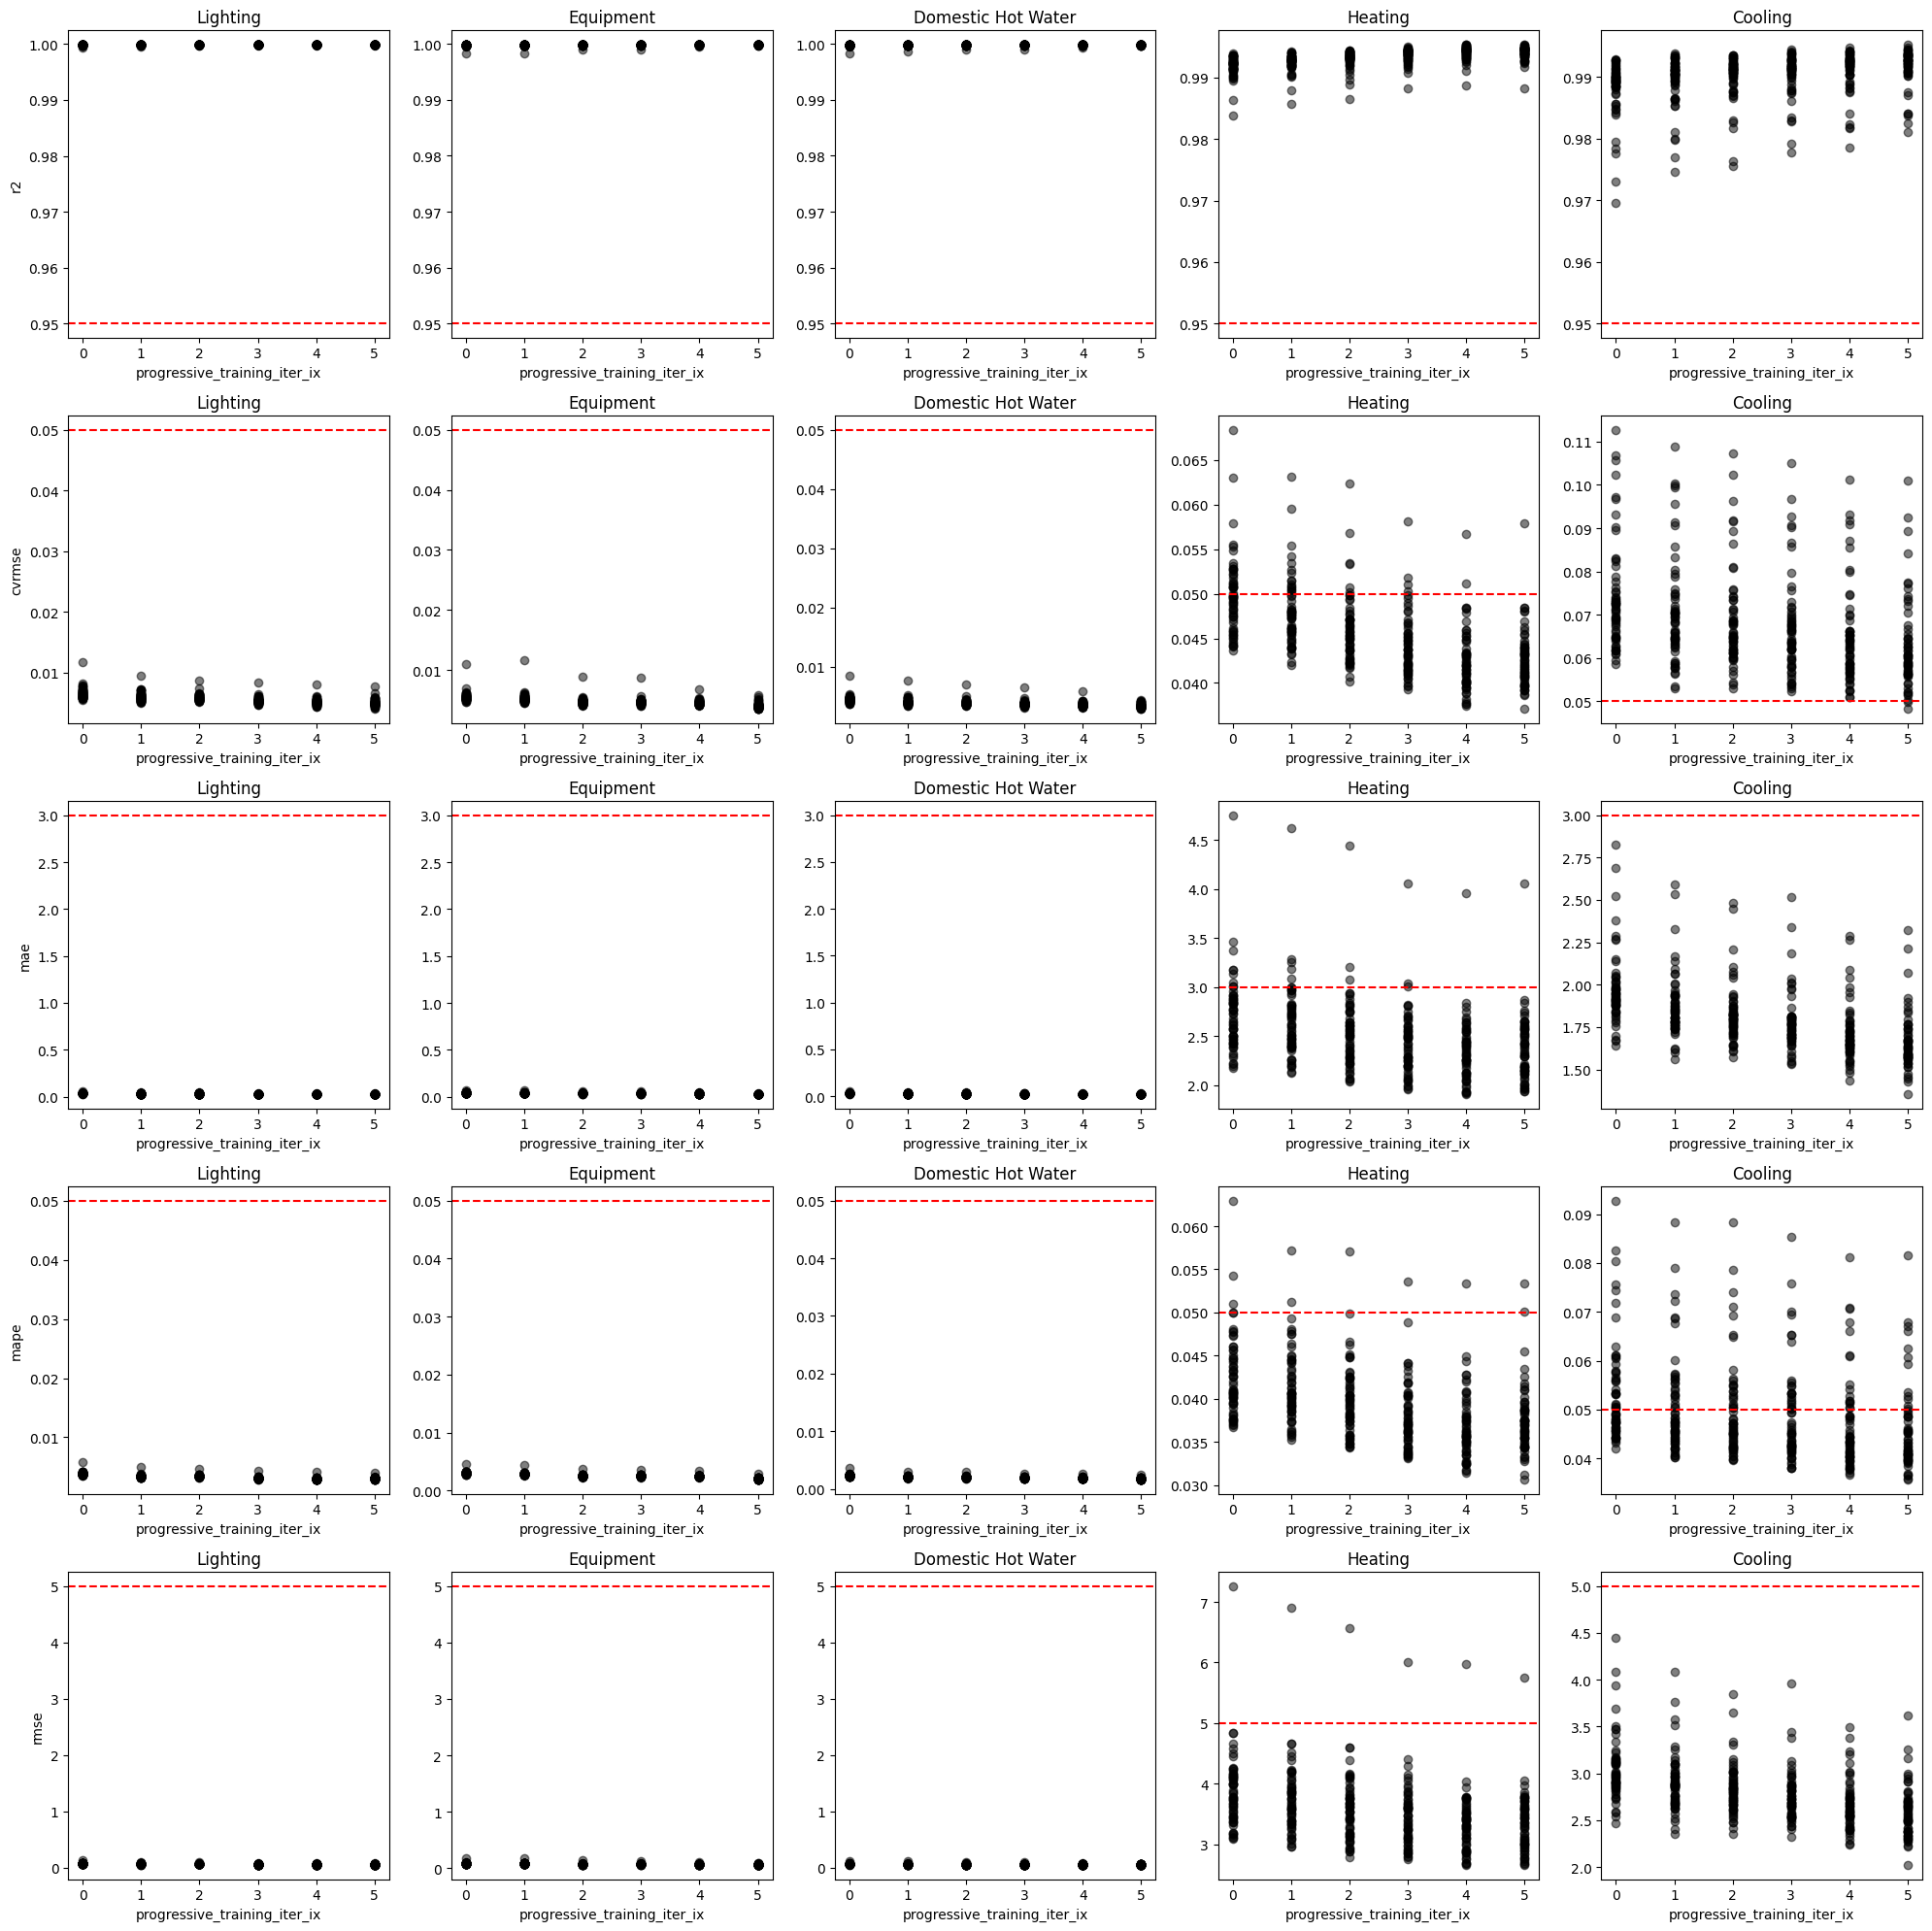

In [8]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "rmse": 5,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for row_ix, metric in enumerate(["r2", "cvrmse", "mae", "mape", "rmse"]):
    for col_ix, target in enumerate([
        "Lighting",
        "Equipment",
        "Domestic Hot Water",
        "Heating",
        "Cooling",
    ]):
        ax = axs[row_ix, col_ix]
        errs = (
            individual_fold_err_dfs.groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        ax.set_title(target)
        errs.plot(
            marker="o",
            lw=0,
            legend=False,
            ax=ax,
            color="black",
            alpha=0.5,
        )
        ax.axhline(threshes[metric], color="red", linestyle="--")
        if col_ix == 0:
            ax.set_ylabel(metric)
fig.tight_layout()

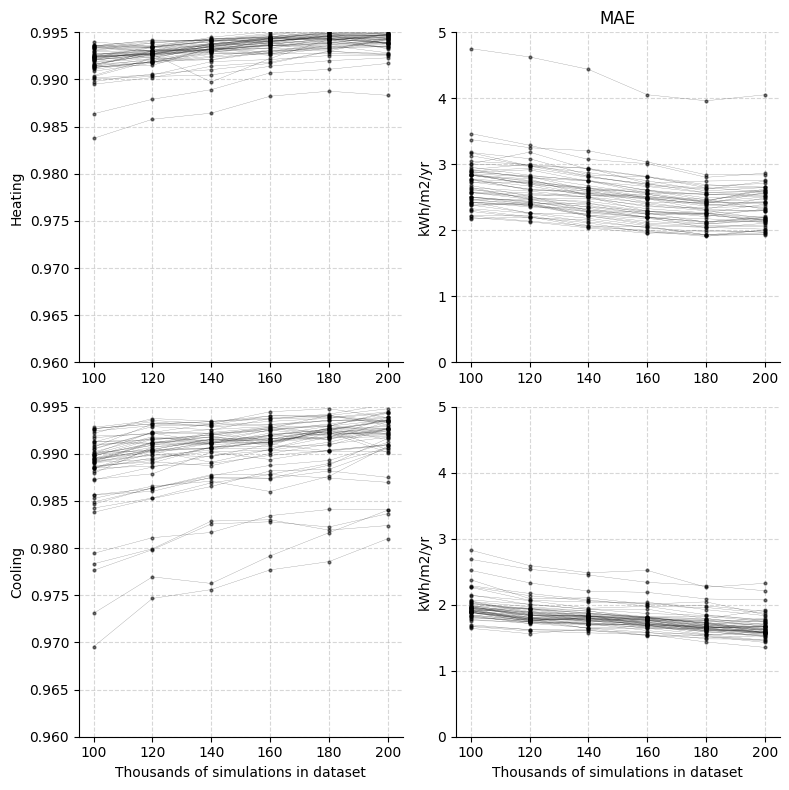

In [47]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "rmse": 5,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for row_ix, metric in enumerate(["r2", "mae"]):
    for col_ix, target in enumerate([
        # "Lighting",
        # "Equipment",
        # "Domestic Hot Water",
        "Heating",
        "Cooling",
    ]):
        ax = axs[col_ix, row_ix]
        errs = (
            individual_fold_err_dfs.groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        if col_ix == 0:
            if metric == "r2":
                ax.set_title("R2 Score")
            if metric == "mae":
                ax.set_title("MAE")
        errs.index = pd.RangeIndex(
            start=100,
            stop=100 + 20 * len(errs),
            step=20,
            name="Thousands of simulations in dataset",
        )
        errs.plot(
            marker="o",
            lw=0.2,
            legend=False,
            ax=ax,
            color="black",
            alpha=0.5,
            markersize=2,
        )
        if col_ix == 0:
            ax.set_xlabel("")
        if row_ix == 0:
            ax.set_ylabel(target)
        if metric == "mae":
            ax.set_ylabel("kWh/m2/yr")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if metric == "r2":
            ax.set_ylim(0.96,0.995)
        if metric == "mae":
            ax.set_ylim(0, 5)
        ax.grid(linestyle="--", alpha=0.5)
fig.tight_layout()


feature.extra_spaces.attic.conditioned  feature.semantic.Typology  feature.semantic.Weatherization
No                                      MFH                        LeakyEnvelope                      105.975476
                                                                   SomewhatLeakyEnvelope               80.716889
                                                                   TightEnvelope                       41.732369
                                        SFH                        LeakyEnvelope                      132.008309
                                                                   SomewhatLeakyEnvelope               81.770461
                                                                   TightEnvelope                       45.946691
Yes                                     MFH                        LeakyEnvelope                       94.027880
                                                                   SomewhatLeakyEnvelope               69.6632

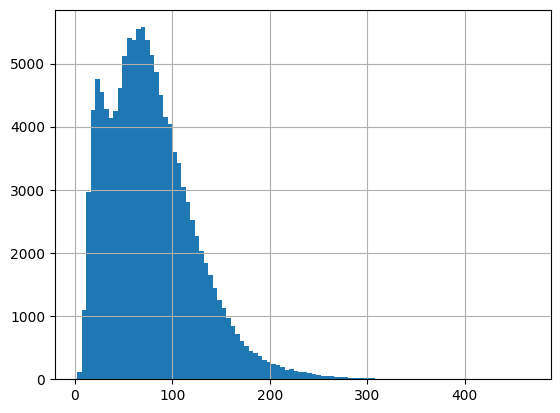

In [120]:
combined_sim_results_annual_raw = (
    combined_sim_results_df["Raw"].T.groupby("Meter").sum().T
)
combined_sim_results_annual_raw["Heating"].hist(bins=100)
combined_sim_results_annual_raw["Equipment"].groupby([
    "Typology",
    "Equipment",
    "Lighting",
]).std()
combined_sim_results_annual_raw["Heating"].groupby(["Typology"]).std()
combined_sim_results_annual_raw["Heating"].groupby([
    "feature.extra_spaces.attic.conditioned",
    "feature.semantic.Typology",
    "feature.semantic.Weatherization",
]).mean()

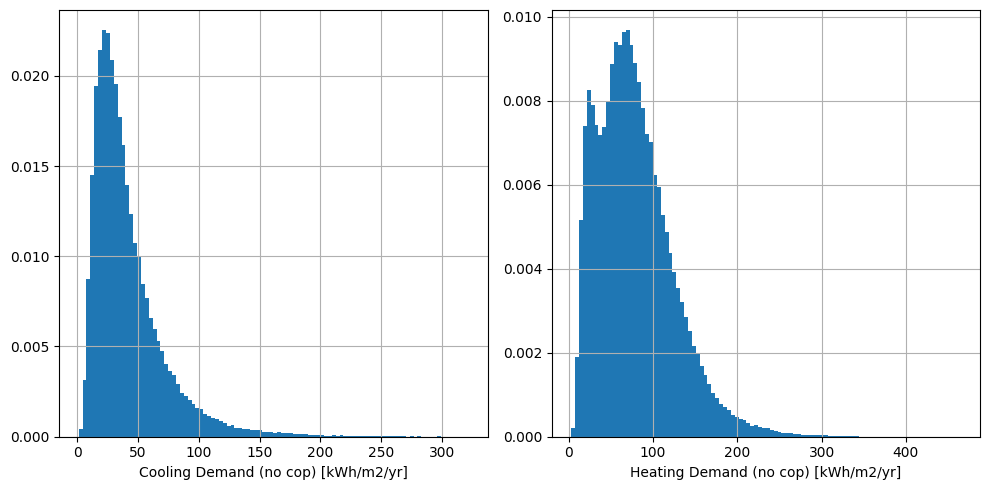

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
combined_sim_results_annual_raw["Cooling"].hist(bins=100, density=True, ax=ax[0])
ax[0].set_xlabel("Cooling Demand (no cop) [kWh/m2/yr]")

combined_sim_results_annual_raw["Heating"].hist(bins=100, density=True, ax=ax[1])
ax[1].set_xlabel("Heating Demand (no cop) [kWh/m2/yr]")
fig.tight_layout()


In [122]:
combined_sim_results_annual_raw.groupby("feature.semantic.Weatherization").mean()


Meter,Cooling,Domestic Hot Water,Equipment,Heating,Lighting
feature.semantic.Weatherization,,,,,
LeakyEnvelope,41.567763,13.707205,15.372244,115.492346,10.574827
SomewhatLeakyEnvelope,42.563162,13.712385,15.396363,78.938028,10.570419
TightEnvelope,42.208315,13.717667,15.393185,41.666712,10.522387


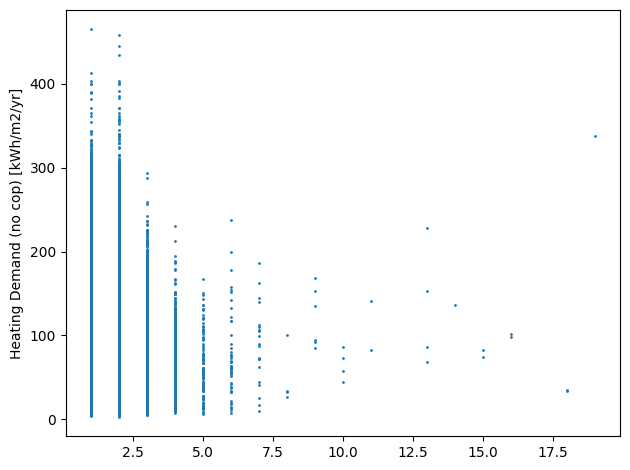

In [123]:
x = combined_sim_results_df.index.get_level_values("feature.geometry.num_floors").values
y = combined_sim_results_annual_raw["Heating"].values

fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
# ax.set_xlabel("Total Conditioned Area [m2]")
ax.set_ylabel("Heating Demand (no cop) [kWh/m2/yr]")
# ax.set_xlim(0, 10000)
fig.tight_layout()


In [124]:
combined_sim_results_annual_raw.xs(
    "SomewhatLeakyEnvelope", level="feature.semantic.Weatherization"
).groupby([
    "feature.semantic.Age_bracket",
    "feature.semantic.Walls",
]).mean()["Heating"].sort_values()
# df.xs("USA_MA_Boston.994971_TMYx.2009-2023.zip", level="feature.weather.file").groupby(["feature.semantic.Typology", "feature.semantic.Age_bracket", "feature.semantic.Weatherization", ]).size()

feature.semantic.Age_bracket  feature.semantic.Walls           
pre_1975                      FullInsulationWallsCavityExterior    68.077942
post_2003                     FullInsulationWallsCavity            68.236243
                              FullInsulationWallsCavityExterior    68.253097
btw_1975_2003                 FullInsulationWallsCavity            69.332217
pre_1975                      FullInsulationWallsCavity            70.349825
btw_1975_2003                 FullInsulationWallsCavityExterior    70.384274
post_2003                     SomeInsulationWalls                  73.739433
btw_1975_2003                 SomeInsulationWalls                  75.664013
pre_1975                      SomeInsulationWalls                  79.613614
btw_1975_2003                 UninsulatedWalls                     86.450155
post_2003                     UninsulatedWalls                     86.595707
pre_1975                      SIP                                  88.675277
btw_1975_200

In [125]:
combined_sim_results_annual_raw.groupby("feature.weather.file").mean()[
    "Heating"
].sort_values()

feature.weather.file
USA_MA_Chatham.Muni.AP.725069_TMYx.2009-2023                               59.236043
USA_MA_Woods.Hole.997274_TMYx.2009-2023                                    59.246075
USA_MA_Waquiot.Bay.Reserve.998014_TMYx.2009-2023                           59.632833
USA_MA_Nantucket.Island.994046_TMYx.2007-2021                              61.332171
USA_MA_Fall.River.Harbor.997279_TMYx.2004-2018                             62.640146
USA_MA_Barnstable.Muni.AP-Boardman.Polando.Field.725067_TMYx               65.712673
USA_MA_Marthas.Vineyard.AP.725066_TMYx                                     65.794884
USA_RI_Providence.Harbor.997278_TMYx.2004-2018                             66.138797
USA_MA_Marshfield.Muni.AP-Harlow.Field.722256_TMYx.2009-2023               66.315965
USA_MA_Boston.994971_TMYx.2009-2023                                        66.711028
USA_NY_Hudson.River.Reserve.997991_TMYx.2004-2018                          67.289680
USA_MA_Fall.River.Harbor.997279_TMYx        

In [59]:
feats = combined_sim_results_df.index.to_frame(index=False)[
    [
        col
        for col in combined_sim_results_df.index.names
        if "feature" in col and "shading" not in col
    ]
]
feats.columns

Index(['feature.geometry.long_edge', 'feature.geometry.short_edge',
       'feature.geometry.orientation', 'feature.geometry.orientation.cos',
       'feature.geometry.orientation.sin', 'feature.geometry.aspect_ratio',
       'feature.geometry.wwr', 'feature.geometry.num_floors',
       'feature.geometry.f2f_height', 'feature.geometry.zoning',
       ...
       'feature.weather.monthly.dd_heating.11',
       'feature.weather.monthly.dd_heating.12',
       'feature.extra_spaces.basement.exists',
       'feature.extra_spaces.basement.occupied',
       'feature.extra_spaces.basement.conditioned',
       'feature.extra_spaces.basement.use_fraction',
       'feature.extra_spaces.attic.exists',
       'feature.extra_spaces.attic.occupied',
       'feature.extra_spaces.attic.conditioned',
       'feature.extra_spaces.attic.use_fraction'],
      dtype='object', length=145)

## Retraining

In [139]:
final_combined_sim_results_uri

's3://ml-for-bem/hatchet/ma-webapp/v1-20250410-135156/iter-005/sample/full-dataset.pq'

In [142]:
from epengine.models.train_sbem import TrainFoldSpec

spec = TrainFoldSpec(
    n_folds=5,
    data_uri=final_combined_sim_results_uri,
    stratification_field="feature.weather.file",
    progressive_training_iter_ix=0,
    experiment_id=experiment_id,
    sort_index=0,
    bucket="ml-for-bem",
)


In [134]:
train_features, train_targets = spec.train_segment
normalized_features = spec.normalize_params(train_features)
# for col in normalized_features.columns:
#     try:
#         col_vals = normalized_features[col].values.astype(float)
#         district_heating = train_targets["Heating"].values
#         correlation = np.corrcoef(col_vals, district_heating)[0, 1]
#         print(f"{col}: {correlation}")
#     except Exception as e:
#         print(type(col_vals))
#         print(f"{col} ERROR {e}")


### XGB

In [4]:
import xgboost as xgb

xgb_hyperparams = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 5,  # 7
    "eta": 0.1,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    # "alpha": 0.01,
    # "lambda": 0.01,
    # "gamma": 0.01,
}

train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_features_mask = (train_features["feature.geometry.long_edge"] > 5) & (
    train_features["feature.geometry.short_edge"] > 5
)
test_features_mask = (test_features["feature.geometry.long_edge"] > 5) & (
    test_features["feature.geometry.short_edge"] > 5
)

train_features = train_features[train_features_mask]
test_features = test_features[test_features_mask]
train_targets = train_targets[train_features_mask.values]
test_targets = test_targets[test_features_mask.values]

train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)

train_dmatrix = xgb.DMatrix(train_features_norm, label=train_targets)
test_dmatrix = xgb.DMatrix(test_features_norm, label=test_targets)

if False:
    model = xgb.train(
        xgb_hyperparams,
        train_dmatrix,
        num_boost_round=2000,
        evals=[(test_dmatrix, "eval")],
        early_stopping_rounds=20,
    )


### LGB Curves

In [147]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from tqdm.autonotebook import tqdm

train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
print(len(train_features), len(test_features))
train_features_mask = (train_features["feature.geometry.long_edge"] > 3) & (
    train_features["feature.geometry.short_edge"] > 3
)
test_features_mask = (test_features["feature.geometry.long_edge"] > 3) & (
    test_features["feature.geometry.short_edge"] > 3
)
train_features = train_features[train_features_mask]
test_features = test_features[test_features_mask]
train_targets = train_targets[train_features_mask.values]
test_targets = test_targets[test_features_mask.values]
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)

all_iter_err_dfs = []
for frac in tqdm(np.linspace(0.1, 1.0, 19), total=39):
    iter_err_dfs = {}
    for end_use in ["Heating", "Cooling"]:
        n_train = int(len(train_features_norm) * frac)
        n_test = len(test_features_norm)
        lgb_train_data = lgb.Dataset(
            train_features_norm.sample(frac=1, random_state=42).iloc[:n_train],
            label=train_targets[end_use].sample(frac=1, random_state=42).iloc[:n_train],
        )
        lgb_test_data = lgb.Dataset(
            test_features_norm.sample(frac=1, random_state=42).iloc[:n_test],
            label=test_targets[end_use].sample(frac=1, random_state=42).iloc[:n_test],
        )

        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            # "max_depth": 5,
            # "learning_rate": 0.1,
            # "num_leaves": 100,
        }

        model = lgb.train(
            lgb_params,
            lgb_train_data,
            num_boost_round=4000,
            valid_sets=[lgb_test_data],
            valid_names=["eval"],
            callbacks=[lgb.early_stopping(20)],
        )

        test_preds = model.predict(test_features_norm)

        test_preds = pd.Series(test_preds, index=test_targets.index, name=end_use)
        test_trues = test_targets[end_use]

        residuals = test_trues - test_preds
        maes = {}
        mapes = {}
        r2s = {}
        cvrmses = {}
        for file in test_targets.index.get_level_values(
            "feature.weather.file"
        ).unique():
            test_trues_file = test_trues.xs(file, level="feature.weather.file")
            test_preds_file = test_preds.xs(file, level="feature.weather.file")
            mae = mean_absolute_error(test_trues_file, test_preds_file)
            mape = mean_absolute_percentage_error(test_trues_file, test_preds_file)
            r2 = r2_score(test_trues_file, test_preds_file)
            cvrmse = (
                np.sqrt(np.mean((test_trues_file - test_preds_file) ** 2))
                / test_trues_file.mean()
            )
            maes[file] = mae
            mapes[file] = mape
            r2s[file] = r2
            cvrmses[file] = cvrmse
        maes = pd.Series(maes, name="mae")
        mapes = pd.Series(mapes, name="mape")
        r2s = pd.Series(r2s, name="r2")
        cvrmses = pd.Series(cvrmses, name="cvrmse")
        iter_df = pd.concat([maes, mapes, r2s, cvrmses], axis=1)
        iter_df.index.name = "stratum"
        iter_df = iter_df.set_index(
            pd.Series([frac] * len(iter_df), name="frac"), append=True
        )
        iter_err_dfs[end_use] = iter_df
    iter_err_df = pd.concat(iter_err_dfs, axis=1, names=["metric"])
    all_iter_err_dfs.append(iter_err_df)

all_iter_err_dfs = pd.concat(all_iter_err_dfs, axis=0)
all_iter_err_dfs


159556 39919


KeyboardInterrupt: 

In [148]:
n_train, n_test

(159556, 39919)

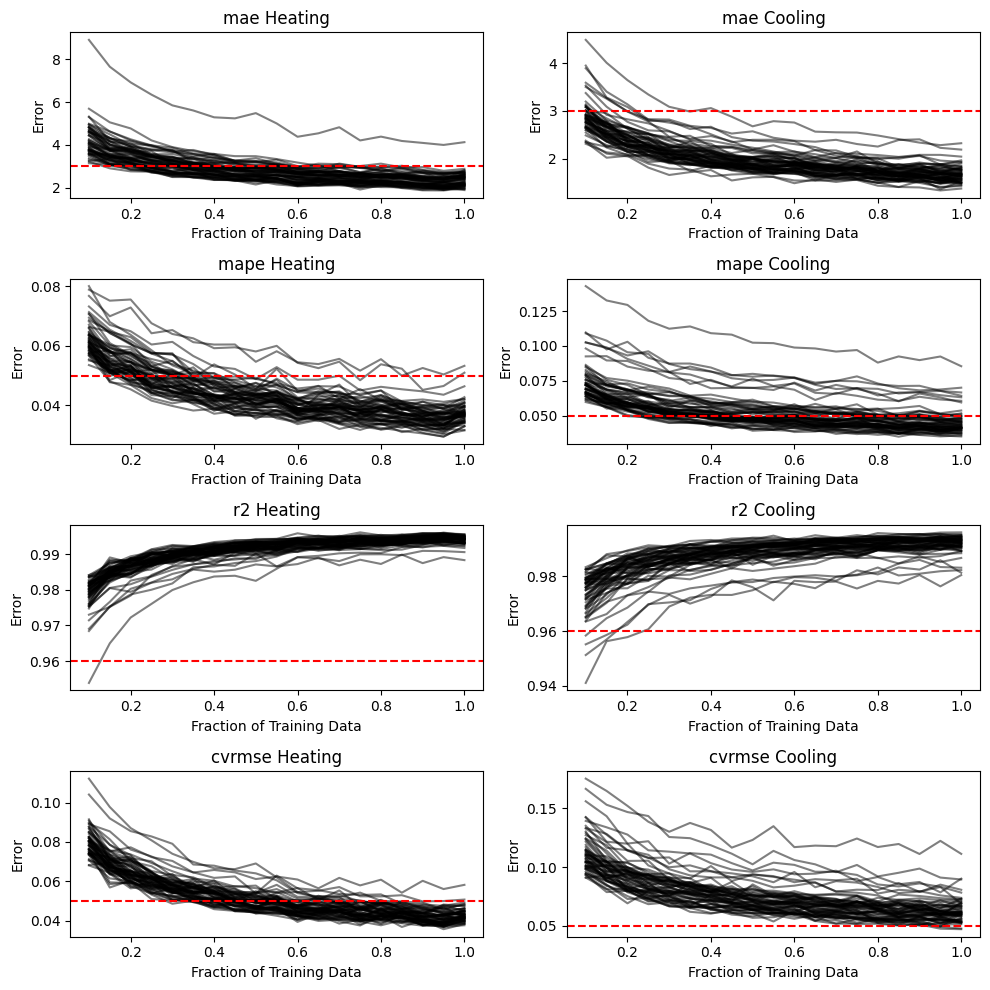

In [149]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.96,
}
targets_to_plot = all_iter_err_dfs.columns.get_level_values(0).unique()
metrics_to_plot = all_iter_err_dfs.columns.get_level_values(1).unique()
fig, ax = plt.subplots(len(metrics_to_plot), len(targets_to_plot), figsize=(10, 10))
for i, metric in enumerate(metrics_to_plot):
    for j, target in enumerate(targets_to_plot):
        data_to_plot = all_iter_err_dfs.xs((target, metric), axis=1).unstack("stratum")
        data_to_plot.plot(ax=ax[i, j], legend=False, color="black", alpha=0.5)
        ax[i, j].axhline(threshes[metric], color="red", linestyle="--")
        ax[i, j].set_title(f"{metric} {target}")
        ax[i, j].set_xlabel("Fraction of Training Data")
        ax[i, j].set_ylabel("Error")
fig.tight_layout()

In [130]:
(
    len(
        spec.data.loc[
            spec.data.index.get_level_values("feature.geometry.short_edge") > 3
        ]
    ),
    len(spec.data),
)

(124587, 124587)

In [346]:
abs_errors = residuals.abs()
worst_semantic_features_fit = combined_sim_results_df.index.to_frame().loc[
    abs_errors.idxmax()
][
    [
        f
        for f in combined_sim_results_df.index.names
        if "feature.weather" not in f and "feature" in f
    ]
]
for feat, val in worst_semantic_features_fit.to_dict().items():
    print(feat, val)


feature.geometry.long_edge 5.271429784946954
feature.geometry.short_edge 3.701633178744034
feature.geometry.orientation 1.9927025937595322
feature.geometry.orientation.cos -0.4095003024173867
feature.geometry.orientation.sin 0.9123099814865936
feature.geometry.aspect_ratio 1.4240821633048883
feature.geometry.wwr 0.19633057497689138
feature.geometry.num_floors 22
feature.geometry.f2f_height 3.632544147914768
feature.geometry.zoning by_storey
feature.geometry.energy_model_conditioned_area 448.79668600172096
feature.geometry.energy_model_occupied_area 448.79668600172096
feature.geometry.attic_height 0.0
feature.geometry.shading_mask_00 0.0
feature.geometry.shading_mask_01 0.0
feature.geometry.shading_mask_02 0.0
feature.geometry.shading_mask_03 0.19065235328834984
feature.geometry.shading_mask_04 0.2358134957866958
feature.geometry.shading_mask_05 0.2187841647435257
feature.geometry.shading_mask_06 0.1979704124449433
feature.geometry.shading_mask_07 0.0
feature.geometry.shading_mask_08 0.

### LGB Full

In [10]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_features_mask = (train_features["feature.geometry.long_edge"] > 3) & (
    train_features["feature.geometry.short_edge"] > 3
)
test_features_mask = (test_features["feature.geometry.long_edge"] > 3) & (
    test_features["feature.geometry.short_edge"] > 3
)
train_features = train_features[train_features_mask]
test_features = test_features[test_features_mask]
train_targets = train_targets[train_features_mask.values]
test_targets = test_targets[test_features_mask.values]
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)
errs_dfs = {}
for end_use in ["Domestic Hot Water", "Lighting", "Equipment", "Heating", "Cooling"]:
    lgb_train_data = lgb.Dataset(
        train_features_norm,
        label=train_targets[end_use],
    )
    lgb_test_data = lgb.Dataset(
        test_features_norm,
        label=test_targets[end_use],
    )

    lgb_params = {
        "objective": "regression",
        "metric": "rmse",
        # "max_depth": 5,
        # "learning_rate": 0.1,
        # "num_leaves": 100,
    }

    model = lgb.train(
        lgb_params,
        lgb_train_data,
        num_boost_round=4000,
        valid_sets=[lgb_test_data],
        valid_names=["eval"],
        callbacks=[lgb.early_stopping(20)],
    )

    test_preds = model.predict(test_features_norm)

    test_preds = pd.Series(test_preds, index=test_targets.index, name=end_use)
    test_trues = test_targets[end_use]

    residuals = test_trues - test_preds
    maes = {}
    mapes = {}
    r2s = {}
    cvrmses = {}
    for file in test_targets.index.get_level_values("feature.weather.file").unique():
        test_trues_file = test_trues.xs(file, level="feature.weather.file")
        test_preds_file = test_preds.xs(file, level="feature.weather.file")
        mae = mean_absolute_error(test_trues_file, test_preds_file)
        mape = mean_absolute_percentage_error(test_trues_file, test_preds_file)
        r2 = r2_score(test_trues_file, test_preds_file)
        cvrmse = (
            np.sqrt(np.mean((test_trues_file - test_preds_file) ** 2))
            / test_trues_file.mean()
        )
        maes[file] = mae
        mapes[file] = mape
        r2s[file] = r2
        cvrmses[file] = cvrmse
    maes = pd.Series(maes, name="mae")
    mapes = pd.Series(mapes, name="mape")
    r2s = pd.Series(r2s, name="r2")
    cvrmses = pd.Series(cvrmses, name="cvrmse")
    iter_df = pd.concat([maes, mapes, r2s, cvrmses], axis=1)
    iter_df.index.name = "stratum"
    errs_dfs[end_use] = iter_df
    with open(f"model_{end_use.replace(' ', '_')}.lgb", "w") as f:
        f.write(model.model_to_string())

err_summary = pd.concat(errs_dfs, axis=1, names=["target"])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19651
[LightGBM] [Info] Number of data points in the train set: 78825, number of used features: 190
[LightGBM] [Info] Start training from score 13.720005
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[708]	eval's rmse: 0.0612057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19651
[LightGBM] [Info] Number of data points in the train set: 78825, number of used features: 190
[LightGBM] [Info] Start training from score 10.568379
Training until validation scores don't improve for 20 rou

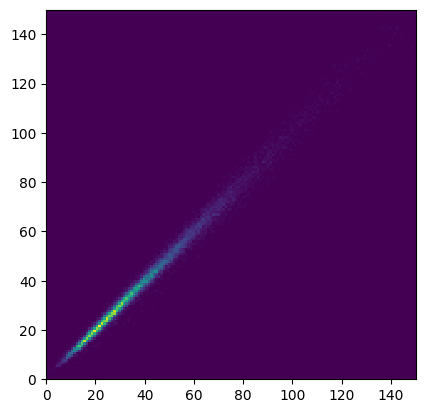

In [ ]:
import matplotlib.pyplot as plt

end_use = "Cooling"
with open(f"model_{end_use.replace(' ', '_')}.lgb") as f:
    model = lgb.Booster(model_str=f.read())
preds = model.predict(test_features_norm)
trues = test_targets[end_use]
_ = plt.hist2d(preds, trues, bins=np.linspace(0, 150, 150))
plt.gca().set_aspect("equal")


### Design Space

In [31]:
for k, v in spec.numeric_min_maxs.items():
    print(k, v)


feature.geometry.long_edge (np.float64(1.8587820232992796), np.float64(204.68179807521815))
feature.geometry.short_edge (np.float64(0.6891672242615761), np.float64(113.49737283820672))
feature.geometry.orientation (np.float64(-3.141582071355473), np.float64(3.1415757612439017))
feature.geometry.orientation.cos (np.float64(-0.9999999999440081), np.float64(0.9999999999897445))
feature.geometry.orientation.sin (np.float64(-0.9999999999962115), np.float64(0.9999999989522861))
feature.geometry.aspect_ratio (np.float64(1.0000031375464564), np.float64(10.810115012699804))
feature.geometry.wwr (np.float64(0.10000053553035589), np.float64(0.29999815390342977))
feature.geometry.num_floors (np.int64(1), np.int64(20))
feature.geometry.f2f_height (np.float64(2.5000164724717124), np.float64(3.9999856490795986))
feature.geometry.energy_model_conditioned_area (np.float64(3.0360651789362496), np.float64(63353.018979244065))
feature.geometry.energy_model_occupied_area (np.float64(3.0360651789362496), np

In [64]:
from epengine.models.transforms import (
    CategoricalFeature,
    ContinuousFeature,
    RegressorInputSpec,
)

feats = []
for feat in spec.train_segment[0].columns:
    if feat in spec.non_numeric_options:
        feats.append(
            CategoricalFeature(name=feat, values=spec.non_numeric_options[feat])
        )
    elif feat in spec.numeric_min_maxs:
        low, high = spec.numeric_min_maxs[feat]
        feats.append(ContinuousFeature(name=feat, min=float(low), max=float(high)))

ds = RegressorInputSpec(features=feats)
import yaml

with open("space.yml", "w") as f:
    yaml.dump(ds.model_dump(), f, indent=2, sort_keys=False)

[
    f.name
    for f in ds.features
    if "weather" not in f.name and "shading_mask" not in f.name
]
[f.name for f in ds.features if "weather" in f.name]


['feature.weather.file',
 'feature.weather.annual.daily_max_median',
 'feature.weather.annual.daily_median_median',
 'feature.weather.annual.daily_min_median',
 'feature.weather.annual.daily_range_median',
 'feature.weather.annual.dd_cooling',
 'feature.weather.annual.dd_heating',
 'feature.weather.latitude',
 'feature.weather.longitude',
 'feature.weather.monthly.daily_max.01',
 'feature.weather.monthly.daily_max.02',
 'feature.weather.monthly.daily_max.03',
 'feature.weather.monthly.daily_max.04',
 'feature.weather.monthly.daily_max.05',
 'feature.weather.monthly.daily_max.06',
 'feature.weather.monthly.daily_max.07',
 'feature.weather.monthly.daily_max.08',
 'feature.weather.monthly.daily_max.09',
 'feature.weather.monthly.daily_max.10',
 'feature.weather.monthly.daily_max.11',
 'feature.weather.monthly.daily_max.12',
 'feature.weather.monthly.daily_max_median.01',
 'feature.weather.monthly.daily_max_median.02',
 'feature.weather.monthly.daily_max_median.03',
 'feature.weather.month

In [58]:
ds = {
    "categorical": spec.non_numeric_options,
    "continuous": {
        k: (float(low), float(high)) for k, (low, high) in spec.numeric_min_maxs.items()
    },
    "params": sorted(
        list(spec.non_numeric_options.keys()) + list(spec.numeric_min_maxs.keys()),
        key=lambda x: spec.train_segment[0].columns.tolist().index(x),
    ),
}
import json

print(json.dumps(ds, indent=4))


{
    "categorical": {
        "feature.geometry.zoning": [
            "by_storey",
            "core/perim"
        ],
        "feature.semantic.DHW": [
            "ElectricResistanceDHW",
            "HPWH",
            "NaturalGasDHW",
            "NaturalGasHeatingDHWCombo"
        ],
        "feature.semantic.Walls": [
            "FullInsulationWallsCavity",
            "FullInsulationWallsCavityExterior",
            "SIP",
            "SomeInsulationWalls",
            "UninsulatedWalls"
        ],
        "feature.semantic.Region": [
            "MA"
        ],
        "feature.semantic.Cooling": [
            "ACCentral",
            "ACWindow",
            "ASHPCooling",
            "GSHPCooling",
            "WindowASHP"
        ],
        "feature.semantic.Heating": [
            "ASHPHeating",
            "ElectricResistance",
            "GSHPHeating",
            "NaturalGasCondensingHeating",
            "NaturalGasHeating",
            "OilHeating"
        ],
      

In [29]:
for k, v in spec.non_numeric_options.items():
    print(k, v)


feature.geometry.zoning ['by_storey', 'core/perim']
feature.semantic.DHW ['ElectricResistanceDHW', 'HPWH', 'NaturalGasDHW', 'NaturalGasHeatingDHWCombo']
feature.semantic.Walls ['FullInsulationWallsCavity', 'FullInsulationWallsCavityExterior', 'SIP', 'SomeInsulationWalls', 'UninsulatedWalls']
feature.semantic.Region ['MA']
feature.semantic.Cooling ['ACCentral', 'ACWindow', 'ASHPCooling', 'GSHPCooling', 'WindowASHP']
feature.semantic.Heating ['ASHPHeating', 'ElectricResistance', 'GSHPHeating', 'NaturalGasCondensingHeating', 'NaturalGasHeating', 'OilHeating']
feature.semantic.Windows ['DoublePaneLowE', 'SinglePane', 'SinglePaneStormWindows', 'TriplePaneLowE']
feature.semantic.Lighting ['LED', 'NoLED']
feature.semantic.Typology ['MFH', 'SFH']
feature.semantic.Equipment ['HighEfficiencyEquipment', 'LowEfficiencyEquipment']
feature.semantic.Thermostat ['Controls', 'NoControls']
feature.semantic.Age_bracket ['btw_1975_2003', 'post_2003', 'pre_1975']
feature.semantic.Distribution ['AirDuctsCon

<Axes: >

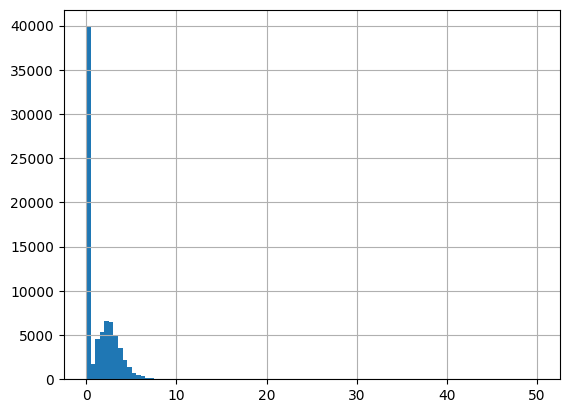

In [ ]:
train_features["feature.geometry.attic_height"].hist(bins=(np.linspace(0, 50, 100)))


np.float64(0.019093262256849226)

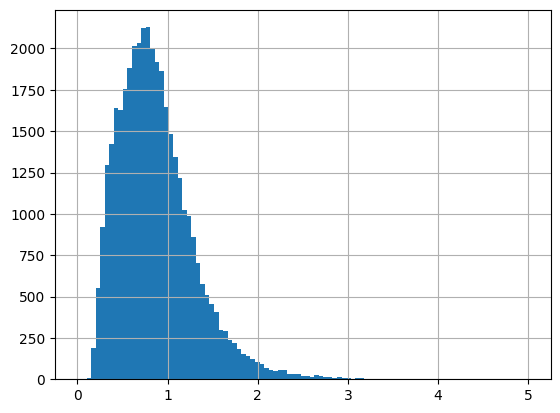

In [53]:
attic_heights = train_features["feature.geometry.attic_height"]
f2f_heights = train_features["feature.geometry.f2f_height"]
ratio = attic_heights / f2f_heights
ratio = ratio[ratio > 0]
ratio.hist(bins=np.linspace(0, 5, 100))
(ratio > 2).mean()


<Axes: >

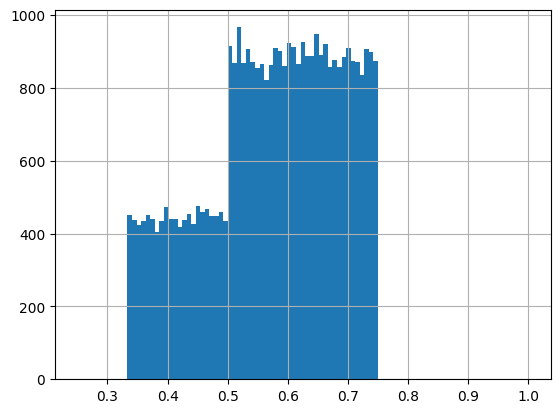

In [50]:
attic_heights = train_features["feature.geometry.attic_height"]
short_edges = train_features["feature.geometry.short_edge"] / 2
(attic_heights / short_edges).hist(bins=np.linspace(3 / 12, 12 / 12, 100))


# Old IDF File Stuff

In [145]:
import asyncio

from archetypal.idfclass import IDF
from epinterface.geometry import match_idf_to_building_and_neighbors

from epengine.models.shoebox import ShoeboxSimulationSpec

df_old = pd.read_parquet(
    "s3://ml-for-bem/hatchet/massachusetts/2024_09_30/residential-v2/specs/832ee29a-1a76-4126-9c83-f08171b5899a/832ee29a-1a76-4126-9c83-f08171b5899a_specs_000000.pq"
)
k = 17
spec_old = ShoeboxSimulationSpec(**df_old.iloc[k].to_dict())

f2f_height = 3.5
model = spec_old.configure(f2f_height=f2f_height)
model.geometry.w, model.geometry.d = model.geometry.d, model.geometry.w

# create a global variable to cache the idf
my_idf: IDF | None = None


def post_build_callback(idf: IDF) -> IDF:
    idf = match_idf_to_building_and_neighbors(
        idf,
        building=spec_old.rotated_rectangle,
        neighbor_polys=spec_old.neighbor_polys,  # pyright: ignore [reportArgumentType]
        neighbor_floors=spec_old.neighbor_floors,  # pyright: ignore [reportArgumentType]
        neighbor_f2f_height=f2f_height,
        target_long_length=spec_old.long_edge,
        target_short_length=spec_old.short_edge,
        rotation_angle=spec_old.long_edge_angle,
    )
    global my_idf
    my_idf = idf
    return idf


weather_dir = Path("notebooks") / "weather"
weather_dir.mkdir(parents=True, exist_ok=True)
from epinterface.climate_studio.builder import SimulationPathConfig

temp_dir = Path("cache") / "temptest"
output_dir = Path(temp_dir)
config = (
    SimulationPathConfig(
        output_dir=output_dir,
        weather_dir=weather_dir,
    )
    if weather_dir is not None
    else SimulationPathConfig(output_dir=output_dir)
)

try:
    idf, sql = await asyncio.to_thread(
        model.simulate,
        config=config,
        post_build_callback=post_build_callback,
    )
except Exception as e:
    print(e)


Adding lights to zone with schedule MA_LIGHTS_SCHEDULE.  Make sure this schedule exists.
Ignoring IlluminanceTarget for zone(s) Conditioned_Zones.
Adding people to zone with schedule MA_OCC_SCH.  Make sure this schedule exists.
Ignoring AirspeedSchedule for zone(s) Conditioned_Zones.
Adding equipment to zone with schedule MA_EQUIP_SCHEDULE.  Make sure this schedule exists.
Mechanical ventilation schedule is being ignored in zone Block shoebox Storey 0.
Exception in thread ExpandObjects_Minimal.idf:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "e:\repos\epengine\.venv\lib\site-packages\archetypal\eplus_interface\expand_objects.py", line 63, in run
    self.p = subprocess.Popen(
  File "C:\tools\Anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\tools\Anaconda3\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid

C:\EnergyPlusV22-2-0\energyplus.exe Minimal.idf: 0it [00:00, ?it/s]

e:\repos\epengine\notebooks\cache\temptest\Minimal.idf:
Program Version,EnergyPlus, Version 22.2.0-c249759bad, YMD=2025.03.19 13:24,
   ** Severe  ** HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   **   ~~~   ** You must run the ExpandObjects program on this input.
   **  Fatal  ** Errors occurred on processing input file. Preceding condition(s) cause termination.
   ...Summary of Errors that led to program termination:
   ..... Reference severe error count=1
   ..... Last severe error=HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   ************* Warning:  Node connection errors not checked - most system input has not been read (see previous warning).
   ************* Fatal error -- final processing.  Program exited before simulations began.  See previous error messages.
   ************* EnergyPlus Warmup Error Summary. During Warmup: 0 Warning; 0 Severe Errors.
   ************* EnergyPlus Sizing Error Su

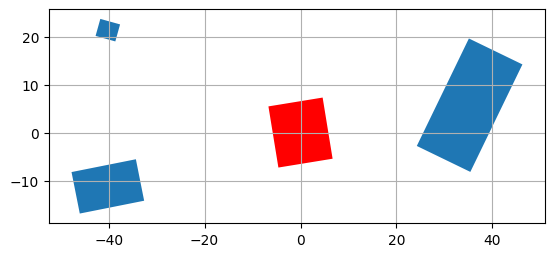

In [146]:
from shapely import from_wkt

rotated_rectangle = from_wkt(spec_old.rotated_rectangle)
neighbor_polys = [from_wkt(poly) for poly in spec_old.neighbor_polys]
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ne = gpd.GeoSeries(neighbor_polys)
bu = gpd.GeoSeries(rotated_rectangle)
ne.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(ax=ax)
bu.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(
    ax=ax, color="red"
)
ax.grid()

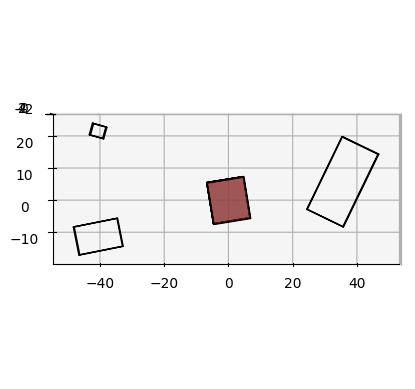

In [147]:
from geomeppy.view_geometry import _get_collection, _get_surfaces

surfaces = _get_surfaces(my_idf)
# set up the collections
walls = _get_collection("wall", surfaces, 0.5, facecolor="lightyellow")
floors = _get_collection("floor", surfaces, 0.5, facecolor="dimgray")
roofs = _get_collection("roof", surfaces, 0.5, facecolor="firebrick")
windows = _get_collection("window", surfaces, 0.5, facecolor="cornflowerblue")
shading = _get_collection("shading", surfaces, 1, facecolor="darkolivegreen")

ax = plt.axes(projection="3d")
ax.add_collection3d(floors)
ax.add_collection3d(walls)
ax.add_collection3d(roofs)
ax.add_collection3d(windows)
ax.add_collection3d(shading)
ax.view_init(elev=90, azim=-90)
ax.set_aspect("equal")
# set the view to be in plane, i.e. from above


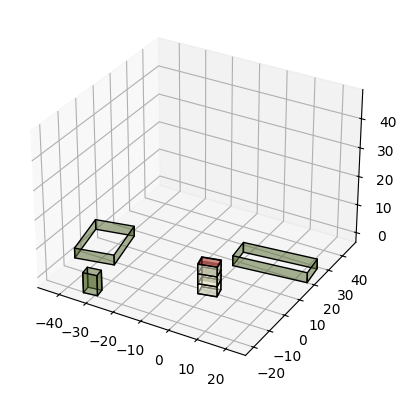

In [136]:
fig, ax = my_idf.view_model()
